In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import random
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Input
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
# 设置随机种子
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

# 加载数据
data = pd.read_csv('/Users/luolan/Desktop/S&P500_data.csv', parse_dates=['Date'], index_col='Date')

# 确保时间索引是日期格式，并设置频率为工作日
data.index = pd.to_datetime(data.index)
data = data.asfreq('B')
data = data.fillna(method='ffill').fillna(method='bfill')

# 计算技术指标
data['SMA_14'] = data['Close'].rolling(window=14).mean()
data['SMA_50'] = data['Close'].rolling(window=50).mean()
data['SMA_200'] = data['Close'].rolling(window=200).mean()

def calculate_macd(data, short_window=12, long_window=26, signal_window=9):
    short_ema = data['Close'].ewm(span=short_window, adjust=False).mean()
    long_ema = data['Close'].ewm(span=long_window, adjust=False).mean()
    macd = short_ema - long_ema
    signal_line = macd.ewm(span=signal_window, adjust=False).mean()
    return macd, signal_line

data['MACD'], data['Signal_Line'] = calculate_macd(data)

def calculate_rsi(data, window):
    diff = data.diff(1)
    gain = diff.where(diff > 0, 0)
    loss = -diff.where(diff < 0, 0)
    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

data['RSI'] = calculate_rsi(data['Close'], 14)

# 数据平滑处理
data['Close_Smoothed'] = data['Close'].rolling(window=5).mean().fillna(method='bfill')

# 删除包含NaN值的行
data = data.dropna()

In [3]:
# 按时间顺序拆分数据集
train_size = int(len(data) * 0.8)
train_data = data[:train_size]
test_data = data[train_size:]

# 标准化数据
features = ['Open', 'High', 'Low', 'Close_Smoothed', 'Volume', 'SMA_14', 'SMA_50', 'SMA_200', 'MACD', 'Signal_Line', 'RSI']
scaler = StandardScaler()
train_data_scaled = scaler.fit_transform(train_data[features])
test_data_scaled = scaler.transform(test_data[features])

# 定义窗口化函数
def create_sequences(data, window_size):
    sequences = []
    for i in range(len(data) - window_size):
        sequences.append(data[i:i+window_size])
    return np.array(sequences)

# 窗口大小
window_size = 30

# 创建训练集和测试集序列
train_sequences = create_sequences(train_data_scaled, window_size)
test_sequences = create_sequences(test_data_scaled, window_size)

# 分离输入和输出
X_train = train_sequences[:, :-1]
y_train = train_sequences[:, -1, 3]  # 'Close_Smoothed' 列作为预测目标
X_test = test_sequences[:, :-1]
y_test = test_sequences[:, -1, 3]  # 'Close_Smoothed' 列作为预测目标

# 调整形状为LSTM需要的三维张量
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))

# 建立LSTM模型
model = Sequential()
model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(128, activation='relu', return_sequences=True, kernel_regularizer=l2(0.05)))
model.add(Dropout(0.2))
model.add(LSTM(128, activation='relu', kernel_regularizer=l2(0.05)))
model.add(Dropout(0.2))
model.add(Dense(1))

# 编译模型
model.compile(optimizer='adam', loss='mse')

# 引入早停法
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 查看模型结构
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 29, 128)        │        71,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 29, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 203,393 (794.50 KB)

 Trainable params: 203,393 (794.50 KB)

 Non-trainable params: 0 (0.00 B)

In [4]:
# 训练模型
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=1, callbacks=[early_stop])

Epoch 1/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 8.1186 - val_loss: 1.8129
Epoch 2/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 1.2512 - val_loss: 0.3764
Epoch 3/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.3081 - val_loss: 0.1677
Epoch 4/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.1573 - val_loss: 0.1014
Epoch 5/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.1104 - val_loss: 0.0824
Epoch 6/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0756 - val_loss: 0.0593
Epoch 7/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0593 - val_loss: 0.0940
Epoch 8/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0497 - val_loss: 0.0492
Epoch 9/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0442 - val_loss: 0.0449
Epoch 10/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0367 - val_loss: 0.0431
Epoch 11/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0358 - val_loss: 0.0309
Epoch 12/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step

In [5]:
# 对训练集和测试集进行预测
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# 将预测值转换为一维数组
y_train_pred = y_train_pred.flatten()
y_test_pred = y_test_pred.flatten()

# 获取标准化时使用的均值和标准差
scaler_mean = scaler.mean_[3]  # 第四个特征 'Close_Smoothed' 对应的均值
scaler_scale = scaler.scale_[3]  # 第四个特征 'Close_Smoothed' 对应的标准差

# 对预测值和实际值进行逆标准化
y_train_pred_inverse = y_train_pred * scaler_scale + scaler_mean
y_test_pred_inverse = y_test_pred * scaler_scale + scaler_mean
y_train_inverse = y_train * scaler_scale + scaler_mean
y_test_inverse = y_test * scaler_scale + scaler_mean

# 保存逆标准化后的预测结果到CSV文件
train_results = pd.DataFrame({'Actual': y_train_inverse, 'Prediction': y_train_pred_inverse})
test_results = pd.DataFrame({'Actual': y_test_inverse, 'Prediction': y_test_pred_inverse})

train_results.to_csv('modelLSTM_train_predictions.csv', index=False)
test_results.to_csv('modelLSTM_test_predictions.csv', index=False)

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [6]:
# 计算训练集评估指标（逆标准化后的数据）
mse_train = mean_squared_error(y_train_inverse, y_train_pred_inverse)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(y_train_inverse, y_train_pred_inverse)
r2_train = r2_score(y_train_inverse, y_train_pred_inverse)

print(f'Training Set Metrics (LSTM):')
print(f'MSE: {mse_train}')
print(f'RMSE: {rmse_train}')
print(f'MAE: {mae_train}')
print(f'R²: {r2_train}')

# 计算测试集评估指标（逆标准化后的数据）
mse_test = mean_squared_error(y_test_inverse, y_test_pred_inverse)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test_inverse, y_test_pred_inverse)
r2_test = r2_score(y_test_inverse, y_test_pred_inverse)

print(f'Test Set Metrics (LSTM):')
print(f'MSE: {mse_test}')
print(f'RMSE: {rmse_test}')
print(f'MAE: {mae_test}')
print(f'R²: {r2_test}')

Training Set Metrics (LSTM):
MSE: 3587.4694276102673
RMSE: 59.89548753963246
MAE: 46.81688883292035
R²: 0.9943918690601209
Test Set Metrics (LSTM):
MSE: 7570.522431081551
RMSE: 87.00874916398666
MAE: 68.48025112531042
R²: 0.9669599556795878


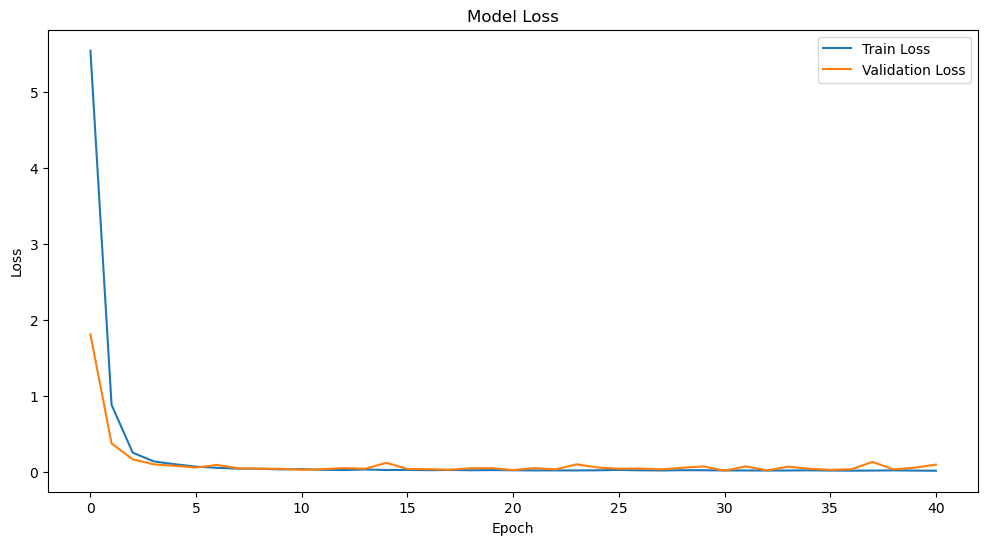

In [7]:
# 绘制损失图
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

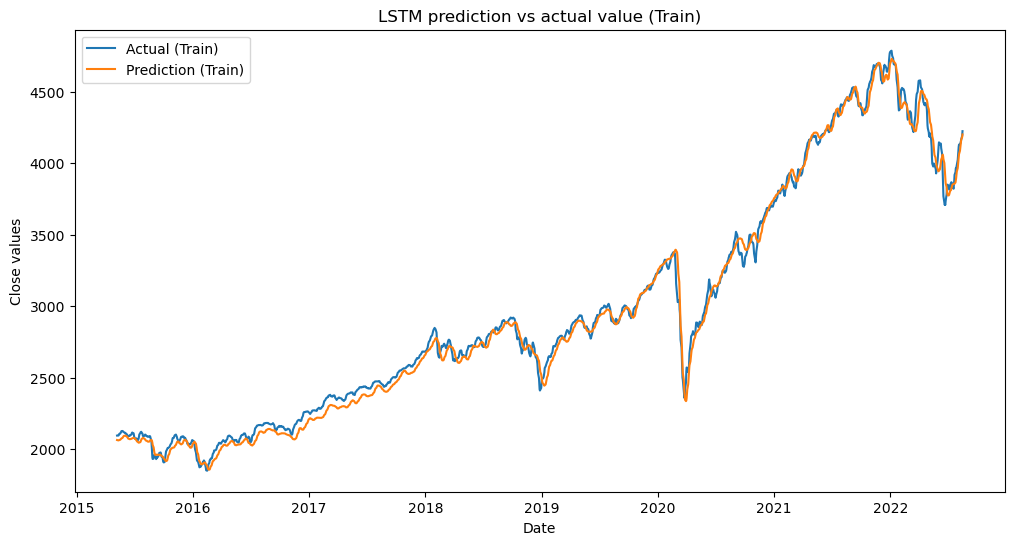

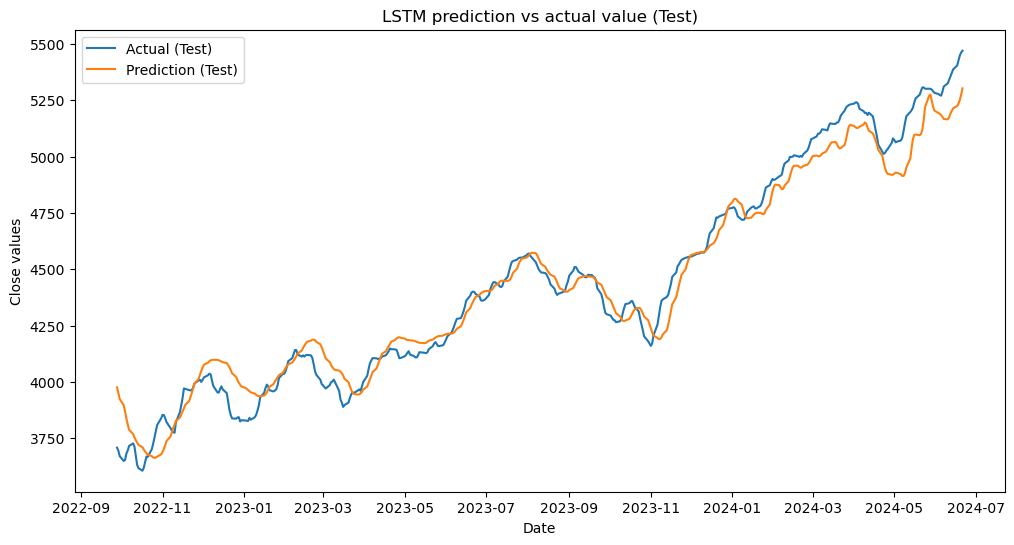

In [9]:
# 获取预测值对应的索引
train_index = train_data.index[window_size:window_size + len(y_train)]
test_index = test_data.index[window_size:window_size + len(y_test)]

# 绘制逆标准化后的训练集预测值与实际值对比图
plt.figure(figsize=(12, 6))
plt.plot(train_index, y_train_inverse, label='Actual (Train)')
plt.plot(train_index, y_train_pred_inverse, label='Prediction (Train)')
plt.title('LSTM prediction vs actual value (Train)')
plt.xlabel('Date')
plt.ylabel('Close values')
plt.legend()
plt.show()

# 绘制逆标准化后的测试集预测值与实际值对比图
plt.figure(figsize=(12, 6))
plt.plot(test_index, y_test_inverse, label='Actual (Test)')
plt.plot(test_index, y_test_pred_inverse, label='Prediction (Test)')
plt.title('LSTM prediction vs actual value (Test)')
plt.xlabel('Date')
plt.ylabel('Close values')
plt.legend()
plt.show()

In [10]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 读取逆标准化后的预测结果
test_results = pd.read_csv('modelLSTM_test_predictions.csv')

# 定义短期预测窗口（例如，10天）
short_term_window = 10

# 提取短期预测和实际值
short_term_actual = test_results['Actual'][:short_term_window]
short_term_predicted = test_results['Prediction'][:short_term_window]

# 计算短期预测的误差指标
mse_short_term = mean_squared_error(short_term_actual, short_term_predicted)
rmse_short_term = np.sqrt(mse_short_term)
mae_short_term = mean_absolute_error(short_term_actual, short_term_predicted)

print("短期预测的误差指标：")
print(f'MSE: {mse_short_term}')
print(f'RMSE: {rmse_short_term}')
print(f'MAE: {mae_short_term}')

# 计算短期预测的准确率（定义误差范围为±5%）
error_margin = 0.05  # 误差范围±5%
accurate_predictions = np.sum(np.abs(short_term_actual - short_term_predicted) <= error_margin * short_term_actual)
accuracy = accurate_predictions / len(short_term_actual)

print("短期预测的准确率：", accuracy)


短期预测的误差指标：
MSE: 35399.48059751773
RMSE: 188.14749692068116
MAE: 166.21170902343744
短期预测的准确率： 0.5


In [11]:
# 定义长期预测窗口（例如，30天）
long_term_window = 1000

# 提取长期预测和实际值
long_term_actual = test_results['Actual'][:long_term_window]
long_term_predicted = test_results['Prediction'][:long_term_window]

# 计算长期预测的误差指标
mse_long_term = mean_squared_error(long_term_actual, long_term_predicted)
rmse_long_term = np.sqrt(mse_long_term)
mae_long_term = mean_absolute_error(long_term_actual, long_term_predicted)

print("长期预测的误差指标：")
print(f'MSE: {mse_long_term}')
print(f'RMSE: {rmse_long_term}')
print(f'MAE: {mae_long_term}')

# 计算长期预测的准确率（定义误差范围为±5%）
error_margin = 0.05  # 误差范围±5%
accurate_predictions_long_term = np.sum(np.abs(long_term_actual - long_term_predicted) <= error_margin * long_term_actual)
accuracy_long_term = accurate_predictions_long_term / len(long_term_actual)

print("长期预测的准确率：", accuracy_long_term)

长期预测的误差指标：
MSE: 7570.522448278444
RMSE: 87.00874926280945
MAE: 68.4802522816639
长期预测的准确率： 0.9845474613686535


Final portfolio value: $13503.35
Maximum Drawdown: $492.32
Sharpe Ratio: 5.23
Win Rate: 84.21%
Total Trades: 39
Annualized Return: 18.19%


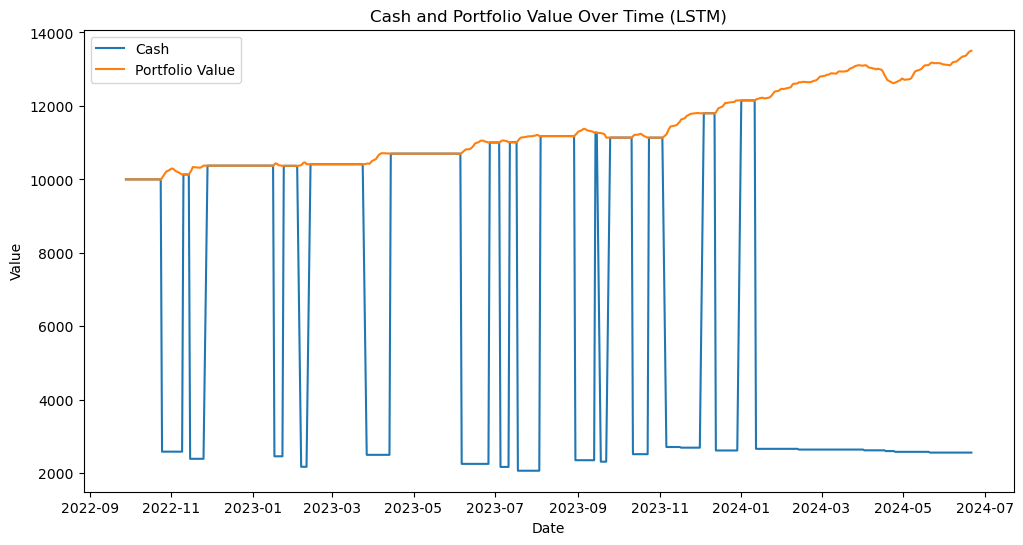

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# 初始化变量
initial_cash = 10000
shares = 0
cash_history = [initial_cash]
portfolio_value_history = []
trades = 0
profits = []
transaction_cost = 0.001  # 交易成本假设为0.1%
previous_price = 0

# 止盈和止损设置
take_profit_threshold = 0.05  # 止盈5%
stop_loss_threshold = 0.02  # 止损2%
min_hold_period = 5  # 最小持有期（以天为单位）
hold_period = 0

# 交易模拟（假设在预测值大于实际值时卖出，小于实际值时买入）
for i in range(len(y_test_inverse)):
    current_price = y_test_inverse[i]
    predicted_price = y_test_pred_inverse[i]

    # 持有股票且达到最小持有期后才检查止盈和止损
    if shares > 0 and hold_period >= min_hold_period:
        current_return = (current_price - previous_price) / previous_price
        if current_return >= take_profit_threshold or current_return <= -stop_loss_threshold:
            trades += 1
            initial_cash += shares * current_price * (1 - transaction_cost)
            profits.append(shares * (current_price - previous_price) * (1 - transaction_cost))
            shares = 0
            hold_period = 0

    # 卖出条件
    if predicted_price > current_price and shares > 0 and hold_period >= min_hold_period:
        trades += 1
        initial_cash += shares * current_price * (1 - transaction_cost)
        if previous_price != 0:
            profits.append(shares * (current_price - previous_price) * (1 - transaction_cost))
        shares = 0
        hold_period = 0
    
    # 买入条件
    elif predicted_price < current_price and initial_cash >= current_price:
        trades += 1
        shares_to_buy = initial_cash // current_price
        previous_price = current_price
        initial_cash -= shares_to_buy * current_price * (1 + transaction_cost)
        shares += shares_to_buy
        hold_period = 0
    
    # 更新持有期
    hold_period += 1

    # 记录当前现金和总资产值
    cash_history.append(initial_cash)
    portfolio_value = initial_cash + shares * current_price
    portfolio_value_history.append(portfolio_value)

# 修正长度以匹配test_index
cash_history = cash_history[:-1]

# 计算最终的资产值
final_value = initial_cash + shares * y_test_inverse[-1]
print(f'Final portfolio value: ${final_value:.2f}')

# 计算最大回撤
drawdown = [max(portfolio_value_history[:i+1]) - portfolio_value_history[i] for i in range(len(portfolio_value_history))]
max_drawdown = max(drawdown)
print(f'Maximum Drawdown: ${max_drawdown:.2f}')

# 计算夏普比率
returns = np.diff(portfolio_value_history) / portfolio_value_history[:-1]
annualized_return = np.mean(returns) * 252
annualized_volatility = np.std(returns) * np.sqrt(252)
sharpe_ratio = annualized_return / annualized_volatility
print(f'Sharpe Ratio: {sharpe_ratio:.2f}')

# 计算胜率
win_rate = sum([1 for profit in profits if profit > 0]) / len(profits) if profits else 0
print(f'Win Rate: {win_rate:.2%}')

# 计算交易次数
print(f'Total Trades: {trades}')

# 计算年化收益率
days = len(y_test_inverse)  # 确认这是实际的交易天数
initial_cash = 10000

# 计算总收益率
total_return = final_value / initial_cash - 1

# 计算年化收益率
annualized_return_percentage = (1 + total_return) ** (252 / days) - 1
annualized_return_percentage = annualized_return_percentage * 100
print(f'Annualized Return: {annualized_return_percentage:.2f}%')

# 绘制现金和资产总值的变化情况
plt.figure(figsize=(12, 6))
plt.plot(test_data.index[window_size:][:len(cash_history)], cash_history, label='Cash')
plt.plot(test_data.index[window_size:][:len(portfolio_value_history)], portfolio_value_history, label='Portfolio Value')
plt.title('Cash and Portfolio Value Over Time (LSTM)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()